# Aula 14 - Vieses em Sistemas de Recomendação - Exercícios

In [3]:
import pandas as pd
import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNBasic

## Vídeos de Apoio

https://www.youtube.com/watch?v=OSv5J1EVEqA

https://www.youtube.com/watch?v=abGCaK86tY4


## Exercícios de Vieses

### Download do Dataset

In [4]:
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/steam-200k.csv  -O ./steam-200k.csv

--2024-11-19 21:41:02--  https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/steam-200k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2268468 (2.2M) [text/plain]
Saving to: ‘./steam-200k.csv’

./steam-200k.csv    100%[===================>]   2.16M  --.-KB/s    in 0.07s   

2024-11-19 21:41:02 (30.8 MB/s) - ‘./steam-200k.csv’ saved [2268468/2268468]



### Funções comuns

In [44]:
df = pd.read_csv("./steam-200k.csv")
df['hours_played'] = np.log10(df['hours_played'])/np.log10(df['hours_played']).max()
df['user_id'] = df['user_id'].astype(str)
df.head()

train, test = train_test_split(df, test_size=.3, random_state=42)

soma_interacoes_por_jogo = train.groupby('game_title').count()[['hours_played']]
soma_interacoes_por_jogo.columns = ['interactions']

map_soma = soma_interacoes_por_jogo.to_dict()['interactions']

soma_interacoes_por_jogo.head(5)

soma_interacoes_por_jogo_ordenado = soma_interacoes_por_jogo.sort_values('interactions', ascending=False)

map_id = dict(list(enumerate(soma_interacoes_por_jogo_ordenado.index)))
map_id = {v:k for k,v in map_id.items()}

jogos_maior_20porcento_nome = soma_interacoes_por_jogo_ordenado.reset_index().values[:11, 0]
jogos_menor_20porcento_nome = soma_interacoes_por_jogo_ordenado.reset_index().values[-2680:, 0]

jogos_entre_os_20porcento = set(df['game_title']) - set(jogos_maior_20porcento_nome) - set(jogos_menor_20porcento_nome)

In [45]:
block_buster_group = []
niche_group = []
diverse_group = []

for user_id in train['user_id'].unique():
    interacted_by_user = train[train['user_id'] == user_id]
    high_pop = interacted_by_user[interacted_by_user['game_title'].isin(jogos_maior_20porcento_nome)]
    lowest_pop = interacted_by_user[interacted_by_user['game_title'].isin(jogos_menor_20porcento_nome)]

    if len(high_pop)/len(interacted_by_user) > 0.5:
        block_buster_group.append(user_id)
    elif len(lowest_pop)/len(interacted_by_user) > 0.5:
        niche_group.append(user_id)
    else:
        diverse_group.append(user_id)


In [46]:
gap_bb_profile = np.mean([calculate_gap_profile(train, i) for i in block_buster_group])
gap_n_profile = np.mean([calculate_gap_profile(train, i) for i in niche_group])
gap_d_profile = np.mean([calculate_gap_profile(train, i) for i in diverse_group])
gap_bb_profile, gap_n_profile, gap_d_profile

(2446.012039943106, 24.63106397647737, 275.0086012684163)

In [47]:
def item_is_relevant(user_id, item_id):
    aux = df[df["user_id"] == user_id]
    if item_id in list(aux['game_title']):
        return True
    return False

def calculate_MRR(map_recommendations):

    MRR = 0
    for user_id in map_recommendations:
        user_find_corerect_item = False
        for index, (item, score) in enumerate(map_recommendations[user_id]):
            if user_find_corerect_item is False:
                if item_is_relevant(user_id, item):
                    MRR += (1/(index+1))
                    user_find_corerect_item = True

    return MRR/len(map_recommendations)


def calculate_gap_profile(train, user_id):
    list_items = train[train['user_id'] == user_id]['game_title'].values
    gap = sum([map_soma[i] for i in list_items])
    return gap/len(list_items)


def calculate_gap(list_items):
    gap = sum([map_soma.get(i, 0) for i in list_items])
    return gap/len(list_items)

def calculate_gap_groups(predictions):
    gap_bb_rec1 = 0
    gap_d_rec1 = 0
    gap_n_rec1 = 0

    n_bb, n_d, n_n = 0, 0, 0

    for user, reclist in zip(test['user_id'].unique()[:200], predictions):
        if user in block_buster_group:
            n_bb += 1
            gap_bb_rec1 += calculate_gap([i[0] for i in predictions[reclist]])
        elif user in niche_group:
            n_n += 1
            gap_n_rec1 += calculate_gap([i[0] for i in predictions[reclist]])
        else:
            n_d += 1
            gap_d_rec1 += calculate_gap([i[0] for i in predictions[reclist]])

    gap_bb_rec1 = gap_bb_rec1/n_bb
    gap_d_rec1 = gap_d_rec1/n_d
    gap_n_rec1 = gap_n_rec1/n_n

    delta_gab_bb = (gap_bb_rec1 - gap_bb_profile )/gap_bb_profile
    delta_gab_d = (gap_d_rec1 - gap_d_profile )/gap_d_profile
    delta_gab_n = (gap_n_rec1 - gap_n_profile )/gap_n_profile

    return delta_gab_bb, delta_gab_d, delta_gab_n

def get_recommendation(model, alpha=0.5):

    prediction_user_map = {}
    prediction_user_map_corrected = {}

    for user in test['user_id'].unique()[:200]:

        data = {"game_title": list(set(df["game_title"].unique()))}
        user_testset_df = pd.DataFrame(data)
        user_testset_df["hours_played"] = 0.0
        user_testset_df["user_id"] = user

        testset = (
            Dataset.load_from_df(
                user_testset_df[["user_id", "game_title", "hours_played"]],
                reader=reader,
            )
            .build_full_trainset()
            .build_testset()
        )

        pred_list = model.test(testset)

        predictions = sorted(
            [(pred.iid, pred.est)for pred in pred_list if ((pred.uid == user))],
            key=lambda x: x[1],reverse=True
        )

        predictions_corrected = sorted(
            [(pred.iid, (1-alpha)*pred.est + (alpha/np.log(map_soma.get(pred.iid, 1)+1)) )for pred in pred_list if ((pred.uid == user))],
            key=lambda x: x[1],reverse=True
        )

        prediction_user_map[user] = predictions[:10]
        prediction_user_map_corrected[user] = predictions_corrected[:10]


    return prediction_user_map, prediction_user_map_corrected

***Exercício 01:*** Explore como outros modelos se comportam em relação ao viés de popularidade. Tente visualizar a distribuição das recomendações e as métricas estudadas.


Evaluating SVD...

Evaluating KNN Basic...
Computing the msd similarity matrix...
Done computing similarity matrix.

Evaluating KNN with Means...
Computing the msd similarity matrix...
Done computing similarity matrix.

Evaluating KNN with ZScore...
Computing the msd similarity matrix...
Done computing similarity matrix.


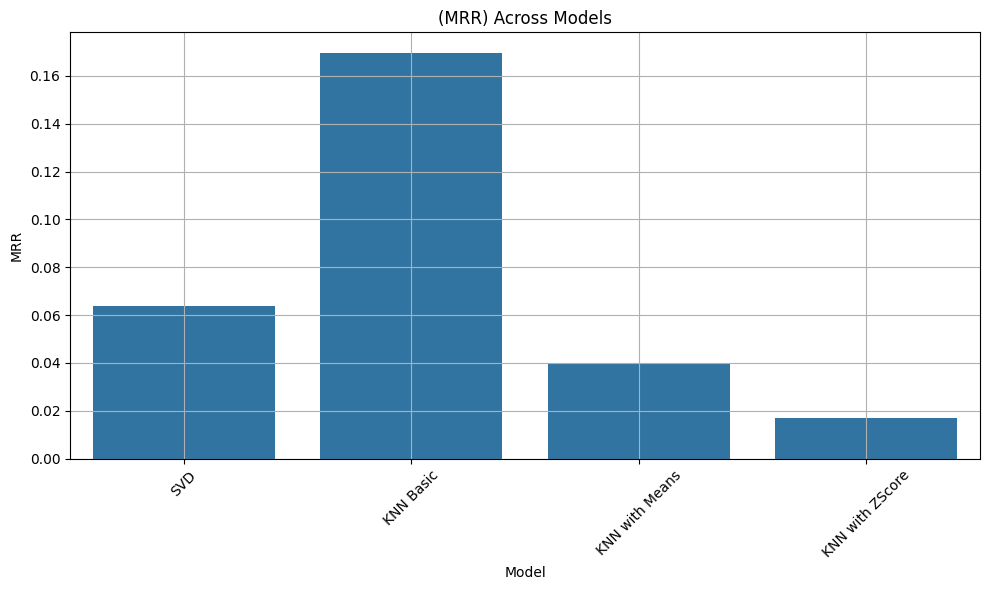

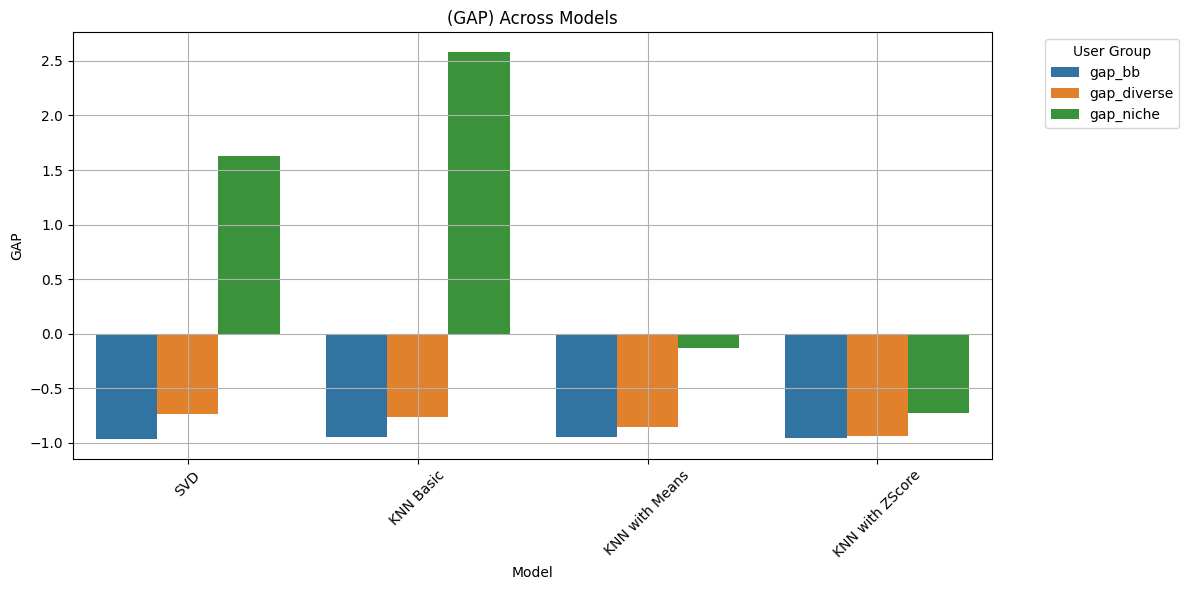


Summary Statistics:

(MRR):
          model      mrr
            SVD 0.063962
      KNN Basic 0.169738
 KNN with Means 0.039756
KNN with ZScore 0.016992

GAP Metrics:
          model    gap_bb  gap_diverse  gap_niche
            SVD -0.965750    -0.731099   1.629606
      KNN Basic -0.945800    -0.759656   2.584092
 KNN with Means -0.945789    -0.858607  -0.127930
KNN with ZScore -0.952658    -0.935329  -0.728392


In [48]:
# Import additional KNN variants
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans, KNNWithZScore

# First calculate profile GAP values for each user group
gap_bb_profile = np.mean([calculate_gap_profile(train, i) for i in block_buster_group])
gap_n_profile = np.mean([calculate_gap_profile(train, i) for i in niche_group])
gap_d_profile = np.mean([calculate_gap_profile(train, i) for i in diverse_group])

# Define models to compare
models = {
    'SVD': SVD(n_factors=30),
    'KNN Basic': KNNBasic(k=20),
    'KNN with Means': KNNWithMeans(k=20),
    'KNN with ZScore': KNNWithZScore(k=20)
}

# Store results
results = {
    'model': [],
    'mrr': [],
    'gap_bb': [],
    'gap_diverse': [],
    'gap_niche': []
}

# Evaluate each model
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    # Train model
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(train[["user_id", "game_title", "hours_played"]], reader)
    model.fit(data.build_full_trainset())

    # Get recommendations
    preds = get_recommendation(model)[0]

    # Calculate metrics
    mrr = calculate_MRR(preds)
    gap_bb, gap_d, gap_n = calculate_gap_groups(preds)

    # Store results
    results['model'].append(name)
    results['mrr'].append(mrr)
    results['gap_bb'].append(gap_bb)
    results['gap_diverse'].append(gap_d)
    results['gap_niche'].append(gap_n)

# Convert to DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Plot MRR comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='model', y='mrr')
plt.title('(MRR) Across Models')
plt.xlabel('Model')
plt.ylabel('MRR')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot GAP metrics comparison
gap_metrics = results_df.melt(
    id_vars=['model'],
    value_vars=['gap_bb', 'gap_diverse', 'gap_niche'],
    var_name='User Group',
    value_name='GAP'
)

plt.figure(figsize=(12, 6))
sns.barplot(data=gap_metrics, x='model', y='GAP', hue='User Group')
plt.title('(GAP) Across Models')
plt.xlabel('Model')
plt.ylabel('GAP')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='User Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("\n(MRR):")
print(results_df[['model', 'mrr']].to_string(index=False))
print("\nGAP Metrics:")
print(results_df[['model', 'gap_bb', 'gap_diverse', 'gap_niche']].to_string(index=False))

***Exercício 02:*** Qual o efeito provocado pela variação do parâmetro $\alpha$? Demonstre como variam as métricas de acurácia e viés de popularidade com a variação do parâmetro.

Training base SVD model...

Testing α = 0

Testing α = 0.2

Testing α = 0.4

Testing α = 0.6

Testing α = 0.8

Testing α = 1.0


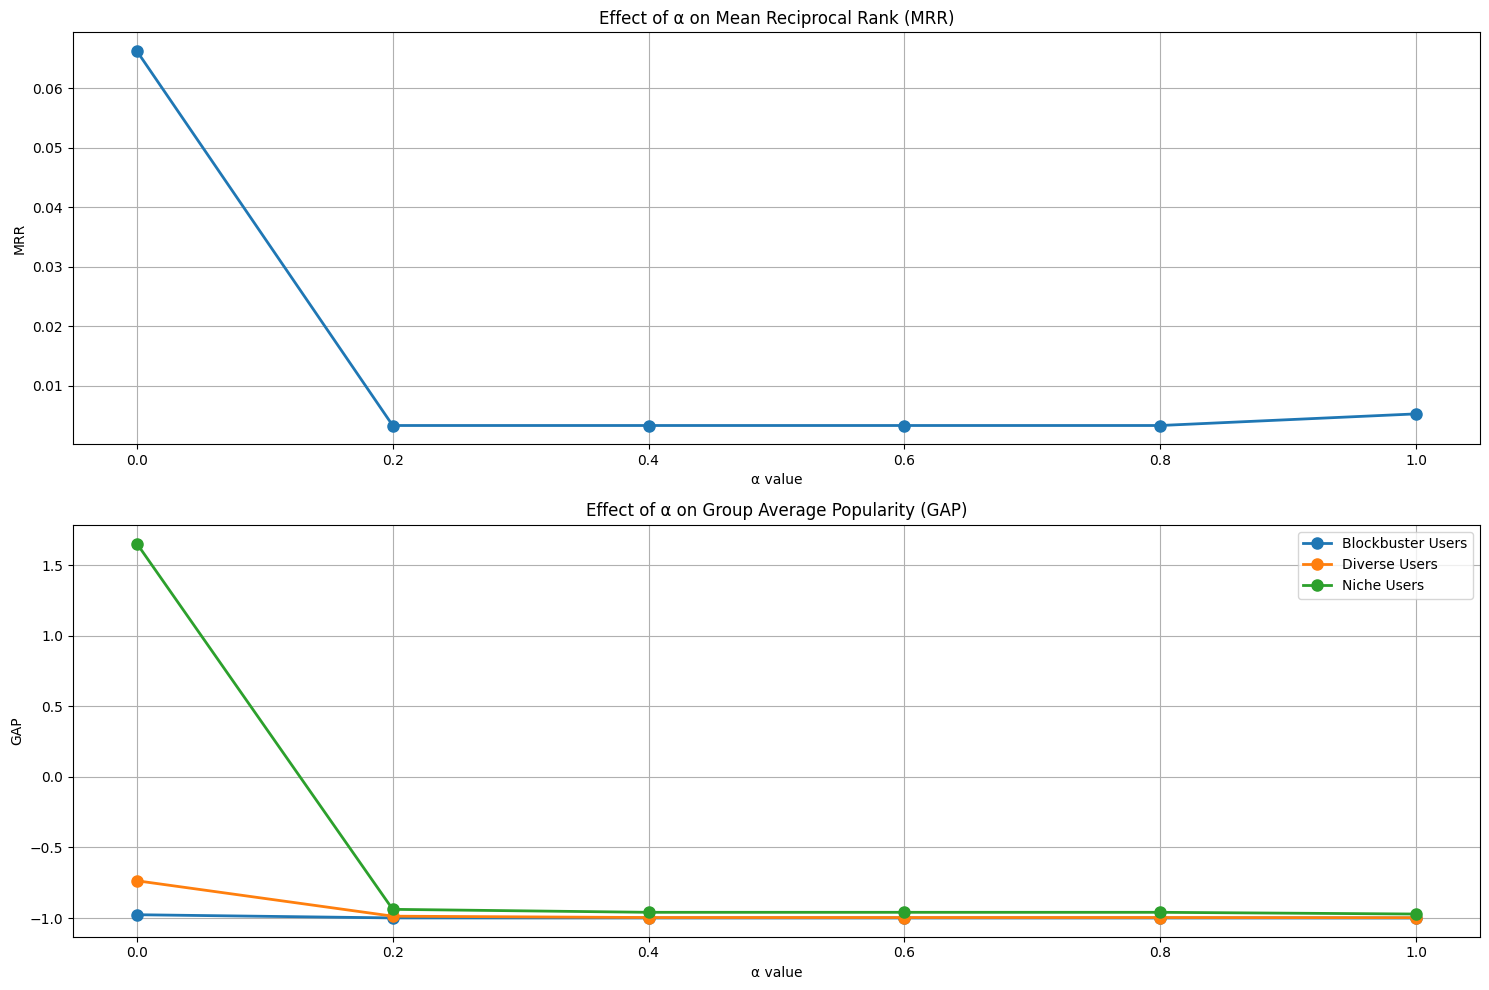

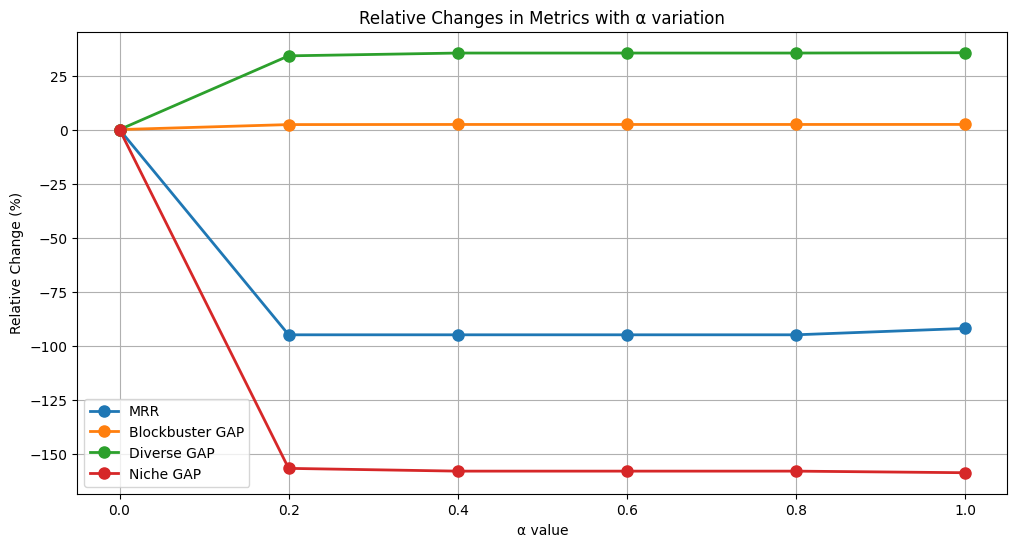


Summary of Results:

Raw Values:
 alpha    mrr  gap_bb  gap_diverse  gap_niche  mrr_change  gap_bb_change  gap_diverse_change  gap_niche_change
   0.0 0.0663 -0.9765      -0.7358     1.6540      0.0000         0.0000              0.0000            0.0000
   0.2 0.0034 -0.9991      -0.9868    -0.9383    -94.9394         2.3132             34.1083         -156.7297
   0.4 0.0034 -0.9996      -0.9964    -0.9594    -94.9394         2.3676             35.4078         -158.0061
   0.6 0.0034 -0.9996      -0.9964    -0.9594    -94.9394         2.3676             35.4078         -158.0061
   0.8 0.0034 -0.9996      -0.9964    -0.9594    -94.9394         2.3676             35.4078         -158.0061
   1.0 0.0053 -0.9997      -0.9975    -0.9716    -91.9928         2.3802             35.5561         -158.7425

Relative Changes (%):
 alpha  mrr_change  gap_bb_change  gap_diverse_change  gap_niche_change
   0.0        0.00           0.00                0.00              0.00
   0.2      -94.94    

In [20]:
# Define alpha values to test
alpha_values = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Store results
results = {
    'alpha': [],
    'mrr': [],
    'gap_bb': [],
    'gap_diverse': [],
    'gap_niche': []
}

# Train base model once
print("Training base SVD model...")
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(train[["user_id", "game_title", "hours_played"]], reader)
model = SVD(n_factors=30)
model.fit(data.build_full_trainset())

# Test different alpha values
for alpha in alpha_values:
    print(f"\nTesting α = {alpha}")

    # Get recommendations with current alpha
    preds, preds_corrected = get_recommendation(model, alpha=alpha)

    # Calculate metrics using corrected predictions
    mrr = calculate_MRR(preds_corrected)
    gap_bb, gap_d, gap_n = calculate_gap_groups(preds_corrected)

    # Store results
    results['alpha'].append(alpha)
    results['mrr'].append(mrr)
    results['gap_bb'].append(gap_bb)
    results['gap_diverse'].append(gap_d)
    results['gap_niche'].append(gap_n)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Create visualization plots
plt.figure(figsize=(15, 10))

# Plot 1: MRR vs Alpha
plt.subplot(2, 1, 1)
plt.plot(results_df['alpha'], results_df['mrr'], 'o-', linewidth=2, markersize=8)
plt.title('Effect of α on Mean Reciprocal Rank (MRR)', fontsize=12)
plt.xlabel('α value')
plt.ylabel('MRR')
plt.grid(True)

# Plot 2: GAP metrics vs Alpha
plt.subplot(2, 1, 2)
plt.plot(results_df['alpha'], results_df['gap_bb'], 'o-', label='Blockbuster Users', linewidth=2, markersize=8)
plt.plot(results_df['alpha'], results_df['gap_diverse'], 'o-', label='Diverse Users', linewidth=2, markersize=8)
plt.plot(results_df['alpha'], results_df['gap_niche'], 'o-', label='Niche Users', linewidth=2, markersize=8)
plt.title('Effect of α on Group Average Popularity (GAP)', fontsize=12)
plt.xlabel('α value')
plt.ylabel('GAP')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate relative changes
baseline_mrr = results_df.loc[results_df['alpha'] == 0, 'mrr'].iloc[0]
baseline_gap_bb = results_df.loc[results_df['alpha'] == 0, 'gap_bb'].iloc[0]
baseline_gap_d = results_df.loc[results_df['alpha'] == 0, 'gap_diverse'].iloc[0]
baseline_gap_n = results_df.loc[results_df['alpha'] == 0, 'gap_niche'].iloc[0]

results_df['mrr_change'] = (results_df['mrr'] / baseline_mrr - 1) * 100
results_df['gap_bb_change'] = (results_df['gap_bb'] / baseline_gap_bb - 1) * 100
results_df['gap_diverse_change'] = (results_df['gap_diverse'] / baseline_gap_d - 1) * 100
results_df['gap_niche_change'] = (results_df['gap_niche'] / baseline_gap_n - 1) * 100

# Plot relative changes
plt.figure(figsize=(12, 6))
plt.plot(results_df['alpha'], results_df['mrr_change'], 'o-', label='MRR', linewidth=2, markersize=8)
plt.plot(results_df['alpha'], results_df['gap_bb_change'], 'o-', label='Blockbuster GAP', linewidth=2, markersize=8)
plt.plot(results_df['alpha'], results_df['gap_diverse_change'], 'o-', label='Diverse GAP', linewidth=2, markersize=8)
plt.plot(results_df['alpha'], results_df['gap_niche_change'], 'o-', label='Niche GAP', linewidth=2, markersize=8)
plt.title('Relative Changes in Metrics with α variation', fontsize=12)
plt.xlabel('α value')
plt.ylabel('Relative Change (%)')
plt.legend()
plt.grid(True)
plt.show()

# Print summary statistics
print("\nSummary of Results:")
print("\nRaw Values:")
print(results_df.round(4).to_string(index=False))
print("\nRelative Changes (%):")
summary_df = results_df[['alpha', 'mrr_change', 'gap_bb_change', 'gap_diverse_change', 'gap_niche_change']]
print(summary_df.round(2).to_string(index=False))

## Exercícios de Fairness

In [21]:
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/ratings.dat  -O ./ratings.dat
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/movies.dat  -O ./movies.dat

--2024-11-19 23:01:12--  https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/ratings.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4318513 (4.1M) [text/plain]
Saving to: ‘./ratings.dat’

./ratings.dat       100%[===================>]   4.12M  --.-KB/s    in 0.08s   

2024-11-19 23:01:12 (50.3 MB/s) - ‘./ratings.dat’ saved [4318513/4318513]

--2024-11-19 23:01:12--  https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/movies.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

In [52]:
df = pd.read_csv("./ratings.dat", sep=",")
df_genres = pd.read_csv("./movies.dat", sep="::", names=['item', 'title', 'genres'], encoding='latin-1')
train, test = train_test_split(df, test_size=.3, random_state=42)
genre_map = {i['item']:i['genres'].split("|") for i in df_genres[['item', 'genres']].to_dict('records')}

<ipython-input-52-e3920f65c9d8>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_genres = pd.read_csv("./movies.dat", sep="::", names=['item', 'title', 'genres'], encoding='latin-1')


### Funções Comuns

In [57]:
def get_user_recommendation_distribution(prediction_user_map):
    user_rec_distribution = {}
    n = 0
    for (item, score) in prediction_user_map:
        for genre in genre_map[item]:
            if genre not in user_rec_distribution:
                user_rec_distribution[genre] = 0
            n += 1
            user_rec_distribution[genre] += 1

    user_rec_distribution = {k: v/n for k, v in sorted(user_rec_distribution.items(), key=lambda item: item[1])}
    return user_rec_distribution


def user_rank_miscalibration(user_profile_dist, rec_profile_dist, alpha=0.001):
    p_g_u = user_profile_dist
    q_g_u = rec_profile_dist

    Ckl = 0
    for genre, p in p_g_u.items():
        q = q_g_u.get(genre, 0.0)
        til_q = (1 - alpha) * q + alpha * p

        if til_q == 0 or p_g_u.get(genre, 0) == 0:
            Ckl = Ckl
        else:
            Ckl += p * np.log2(p / til_q)
    return Ckl

def get_mean_rank_miscalibration(predictions):

    MRMC = 0

    for user in predictions:
        RMC = 0
        user_profile_dist = get_user_profile_distribution(train, user)
        if user_profile_dist == {}:
            continue

        void = user_rank_miscalibration(user_profile_dist, {})
        N = len(predictions[user])
        for i in range(1, N):
            user_rec_dist = get_user_recommendation_distribution(predictions[user][:i])
            kl = user_rank_miscalibration(user_profile_dist, user_rec_dist)
            RMC += kl/void

        MRMC += RMC/N

    return MRMC/len(predictions)

def get_recommendation_raw(model):

    prediction_user_map = {}

    for user in test['user'].unique()[:200]:

        data = {"item": list(set(df["item"].unique()))}
        user_testset_df = pd.DataFrame(data)
        user_testset_df["rating"] = 0.0
        user_testset_df["user"] = user

        testset = (
            Dataset.load_from_df(
                user_testset_df[["user", "item", "rating"]],
                reader=reader,
            )
            .build_full_trainset()
            .build_testset()
        )

        pred_list = model.test(testset)

        predictions = sorted(
            [(pred.iid, pred.est)for pred in pred_list if ((pred.uid == user))],
            key=lambda x: x[1],reverse=True
        )


        prediction_user_map[user] = predictions[:10]


    return prediction_user_map

def rerank_recommendation(profile_dist, list_recomended_items, user, N, tradeoff):
    re_ranked_list = []
    re_ranked_with_score = []

    for _ in range(N):

        max_mmr = -np.inf
        max_item = None
        max_item_rating = None

        for item, rating in list_recomended_items:
            if item in re_ranked_list:
                continue

            temporary_list = re_ranked_list + [item]
            temporary_list_with_score = re_ranked_with_score + [(item, rating)]

            weight_part = sum(
                recomendation[1]
                for recomendation in temporary_list_with_score
            )

            full_tmp_calib = calculate_calibration_sum(
                profile_dist,
                temporary_list_with_score,
                user
            )

            maximized = (1 - tradeoff)*weight_part - tradeoff*full_tmp_calib

            if maximized > max_mmr:
                max_mmr = maximized
                max_item = item
                max_item_rating = rating

        if max_item is not None:
            re_ranked_list.append(max_item)
            re_ranked_with_score.append((max_item, max_item_rating))

    return re_ranked_list, re_ranked_with_score

def calculate_calibration_sum(profile_dist, temporary_list_with_score, user, alpha=0.001):
    kl_div = 0.0
    reco_distr = get_user_recommendation_distribution(temporary_list_with_score)
    for genre, p in profile_dist.items():
        q = reco_distr.get(genre, 0.0)
        til_q = (1 - alpha) * q + alpha * p

        if p == 0.0 or til_q == 0.0:
            kl_div = kl_div
        else:
            kl_div = kl_div + (p * np.log2(p / til_q))
    return kl_div

def get_user_profile_distribution(df, user):
    user_profile_distribution = {}
    n = 0
    for item in df[df['user'] == user]['item'].values:

        for genre in genre_map[item]:
            if genre not in user_profile_distribution:
                user_profile_distribution[genre] = 0
            n += 1
            user_profile_distribution[genre] += 1

    user_profile_distribution = {k: v/n for k, v in sorted(user_profile_distribution.items(), key=lambda item: item[1])}
    return user_profile_distribution


def get_recommendation_fairness(model, lambda_=0.5):

    prediction_user_map = {}

    for user in test['user'].unique()[:200]:

        user_profile_distribution = get_user_profile_distribution(train, user)

        data = {"item": list(set(df["item"].unique()))}
        user_testset_df = pd.DataFrame(data)
        user_testset_df["rating"] = 0.0
        user_testset_df["user"] = user

        testset = (
            Dataset.load_from_df(
                user_testset_df[["user", "item", "rating"]],
                reader=reader,
            )
            .build_full_trainset()
            .build_testset()
        )

        pred_list = model.test(testset)

        predictions = sorted(
            [(pred.iid, pred.est)for pred in pred_list if ((pred.uid == user))],
            key=lambda x: x[1],reverse=True
        )

        reranked_list = rerank_recommendation(
            user_profile_distribution,
            predictions[:100],
            user,
            10,
            lambda_
        )


        prediction_user_map[user] = reranked_list[1]


    return prediction_user_map

def calculate_MRR_2(map_recommendations):
    MRR = 0
    for user in map_recommendations:  # Changed from user_id to user
        user_find_correct_item = False
        for index, (item, score) in enumerate(map_recommendations[user]):  # Changed from game_title to item
            if user_find_correct_item is False:
                if item in list(df[df["user"] == user]['item']):  # Changed column names
                    MRR += (1/(index+1))
                    user_find_correct_item = True

    return MRR/len(map_recommendations)

def get_mean_rank_miscalibration_2(predictions):
    MRMC = 0

    for user in predictions:  # Changed from user_id to user
        RMC = 0
        user_profile_dist = get_user_profile_distribution(train, user)  # This function already uses correct names
        if user_profile_dist == {}:
            continue

        void = user_rank_miscalibration(user_profile_dist, {})
        N = len(predictions[user])
        for i in range(1, N):
            user_rec_dist = get_user_recommendation_distribution(predictions[user][:i])
            kl = user_rank_miscalibration(user_profile_dist, user_rec_dist)
            RMC += kl/void

        MRMC += RMC/N

    return MRMC/len(predictions)

***Exercício 03:*** Explore como outros modelos se comportam com as injustiças relacionadas ao genero do filme. Visualize as métricas para diferentes modelos.


Evaluating SVD...

Evaluating KNN Basic...
Computing the msd similarity matrix...
Done computing similarity matrix.

Evaluating KNN with Means...
Computing the msd similarity matrix...
Done computing similarity matrix.

Evaluating KNN with ZScore...
Computing the msd similarity matrix...
Done computing similarity matrix.


<ipython-input-58-ae31ef2b619f>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='model', y='mrr', palette='viridis')
<ipython-input-58-ae31ef2b619f>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='model', y='mrmc', palette='viridis')


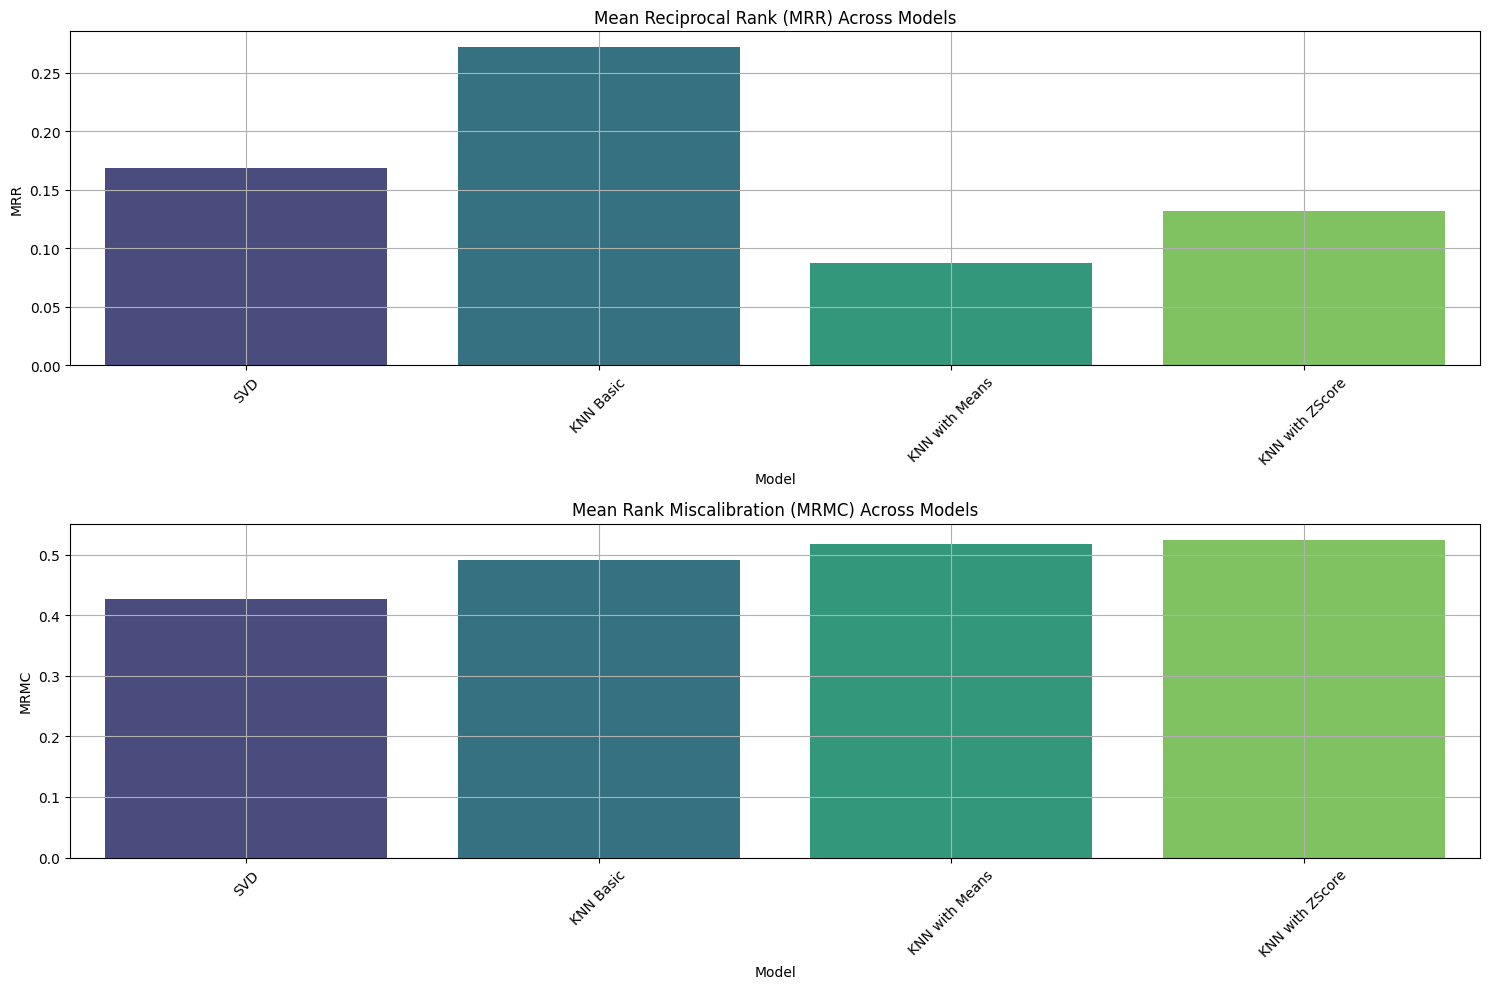

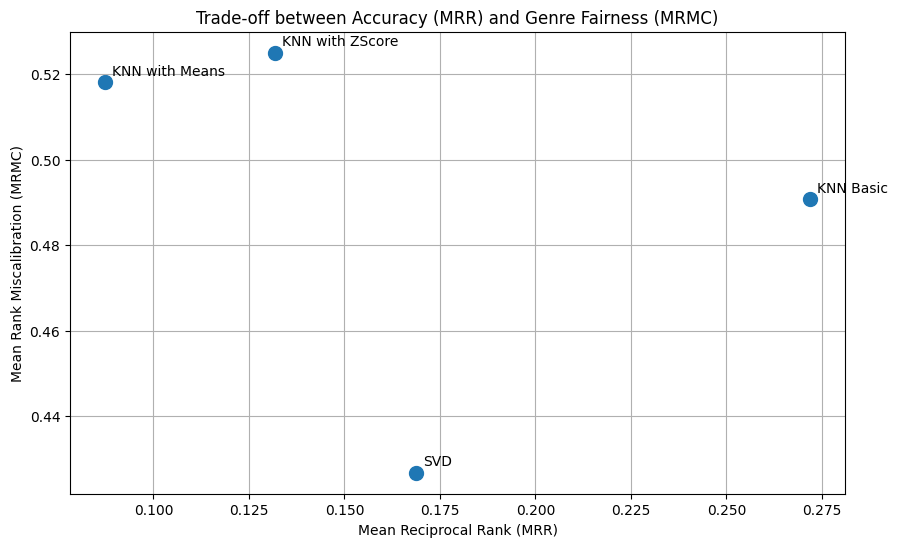


Summary Statistics:
          model    mrr   mrmc
            SVD 0.1687 0.4268
      KNN Basic 0.2718 0.4907
 KNN with Means 0.0874 0.5181
KNN with ZScore 0.1318 0.5250

Best Models:
Best for Accuracy (MRR): KNN Basic
Best for Fairness (MRMC): SVD


In [58]:
# Define models to compare
models = {
    'SVD': SVD(n_factors=30),
    'KNN Basic': KNNBasic(k=20),
    'KNN with Means': KNNWithMeans(k=20),
    'KNN with ZScore': KNNWithZScore(k=20)
}

# Store results
results = {
    'model': [],
    'mrr': [],
    'mrmc': []  # Mean Rank Miscalibration
}

# Create reader object
reader = Reader(rating_scale=(1, 5))

# Evaluate each model
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    # Train model
    data = Dataset.load_from_df(
        train[["user", "item", "rating"]],
        reader
    )
    model.fit(data.build_full_trainset())

    # Get recommendations
    preds = get_recommendation_raw(model)

    # Get fairness recommendations
    preds_fair = get_recommendation_fairness(model, lambda_=0.5)

    # Calculate metrics
    mrr = calculate_MRR_2(preds)
    mrmc = get_mean_rank_miscalibration(preds)

    # Store results
    results['model'].append(name)
    results['mrr'].append(mrr)
    results['mrmc'].append(mrmc)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Create visualization plots
plt.figure(figsize=(15, 10))

# Plot 1: MRR comparison
plt.subplot(2, 1, 1)
sns.barplot(data=results_df, x='model', y='mrr', palette='viridis')
plt.title('Mean Reciprocal Rank (MRR) Across Models', fontsize=12)
plt.xlabel('Model')
plt.ylabel('MRR')
plt.xticks(rotation=45)
plt.grid(True)

# Plot 2: MRMC comparison
plt.subplot(2, 1, 2)
sns.barplot(data=results_df, x='model', y='mrmc', palette='viridis')
plt.title('Mean Rank Miscalibration (MRMC) Across Models', fontsize=12)
plt.xlabel('Model')
plt.ylabel('MRMC')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

# Analyze trade-off between accuracy and fairness
plt.figure(figsize=(10, 6))
plt.scatter(results_df['mrr'], results_df['mrmc'], s=100)
for i, model in enumerate(results_df['model']):
    plt.annotate(model,
                (results_df['mrr'].iloc[i], results_df['mrmc'].iloc[i]),
                xytext=(5, 5), textcoords='offset points')
plt.title('Trade-off between Accuracy (MRR) and Genre Fairness (MRMC)', fontsize=12)
plt.xlabel('Mean Reciprocal Rank (MRR)')
plt.ylabel('Mean Rank Miscalibration (MRMC)')
plt.grid(True)
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(results_df.round(4).to_string(index=False))

# Find best models
best_accuracy = results_df.loc[results_df['mrr'].idxmax(), 'model']
best_fairness = results_df.loc[results_df['mrmc'].idxmin(), 'model']

print("\nBest Models:")
print(f"Best for Accuracy (MRR): {best_accuracy}")
print(f"Best for Fairness (MRMC): {best_fairness}")

***Exercício 04:*** Qual o efeito provocado pela variação do parâmetro $\lambda$ da calibração? Tente visualizar o efeito provocado nas métricas de fairness e acurácia se variarmos o parâmetro lambda.

Training base SVD model...

Testing λ = 0

Testing λ = 0.2

Testing λ = 0.4

Testing λ = 0.6

Testing λ = 0.8

Testing λ = 1.0


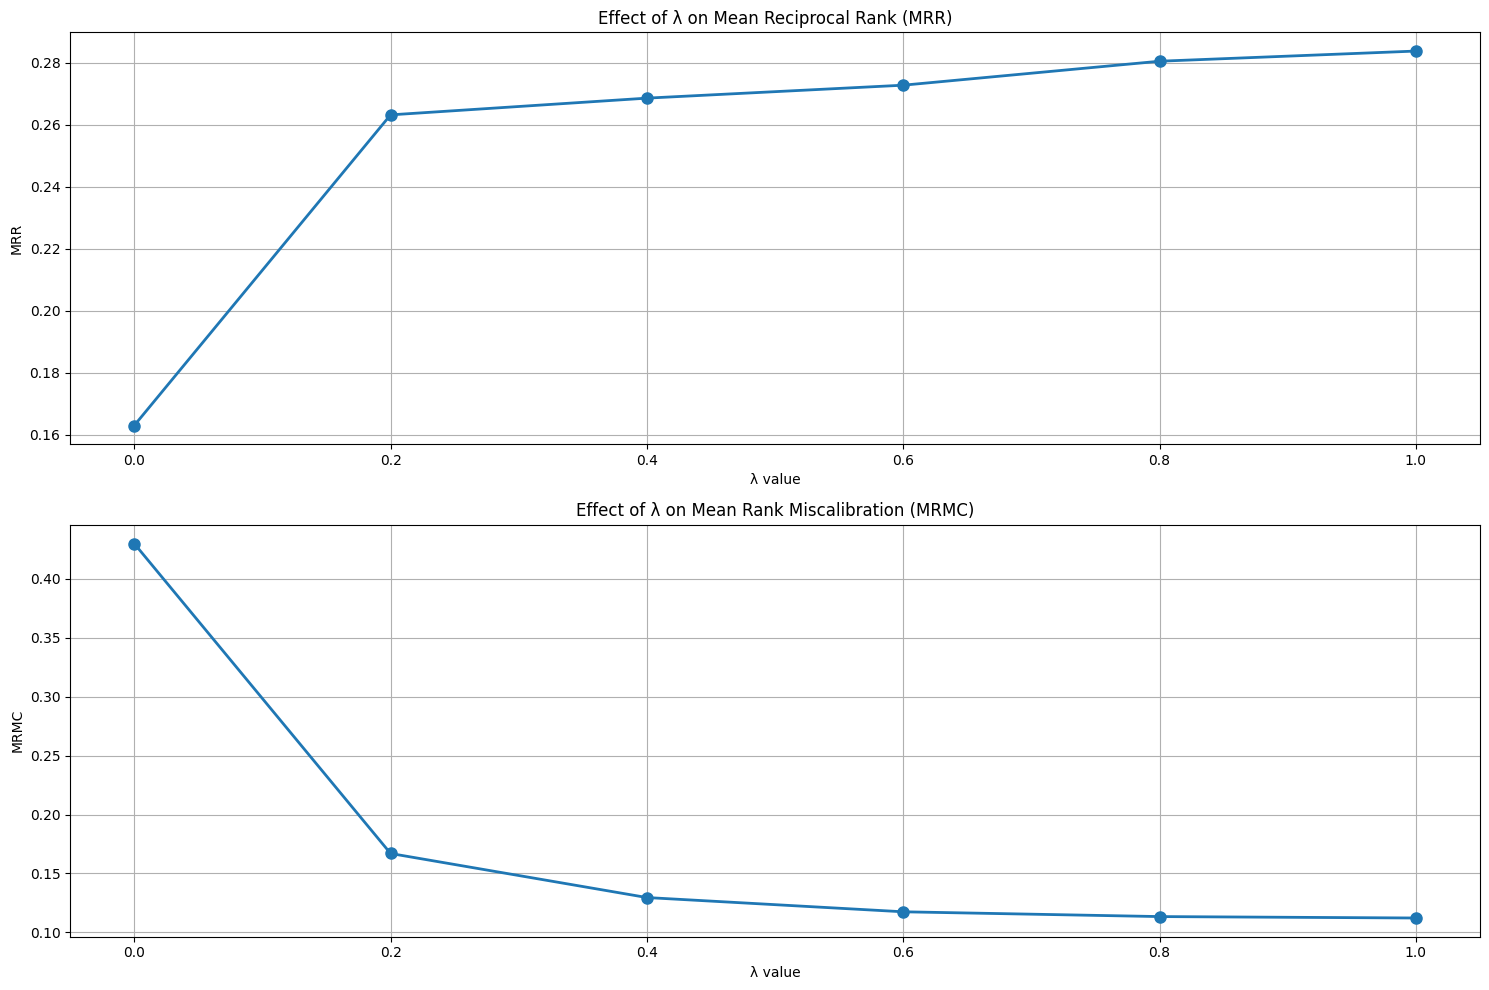

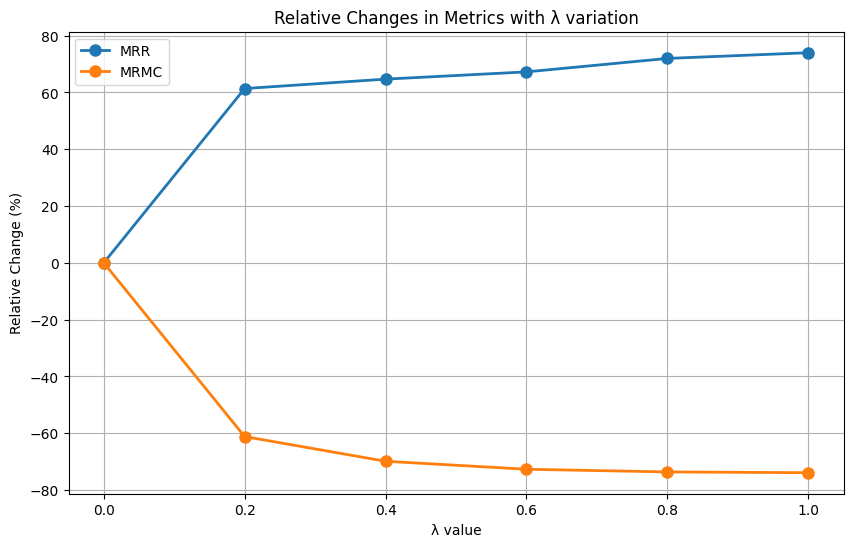


Summary of Results:

Raw Values:
 lambda    mrr   mrmc  mrr_change  mrmc_change
    0.0 0.1631 0.4300      0.0000       0.0000
    0.2 0.2632 0.1669     61.3925     -61.1853
    0.4 0.2686 0.1295     64.6999     -69.8819
    0.6 0.2727 0.1174     67.2576     -72.6950
    0.8 0.2805 0.1134     71.9947     -73.6392
    1.0 0.2837 0.1121     74.0037     -73.9202

Relative Changes (%):
 lambda  mrr_change  mrmc_change
    0.0        0.00         0.00
    0.2       61.39       -61.19
    0.4       64.70       -69.88
    0.6       67.26       -72.69
    0.8       71.99       -73.64
    1.0       74.00       -73.92

Optimal λ value (balancing MRR and MRMC): 1.00

Key Findings:
Best λ for Accuracy (MRR): 1.00
Best λ for Fairness (MRMC): 1.00
Balanced λ: 1.00


In [60]:
# Define lambda values to test
lambda_values = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Store results
results = {
    'lambda': [],
    'mrr': [],
    'mrmc': []
}

# Create reader object
reader = Reader(rating_scale=(1, 5))

# Train base model (using SVD as in previous examples)
print("Training base SVD model...")
model = SVD(n_factors=30)
data = Dataset.load_from_df(train[["user", "item", "rating"]], reader)
model.fit(data.build_full_trainset())

# Test different lambda values
for lambda_val in lambda_values:
    print(f"\nTesting λ = {lambda_val}")

    # Get recommendations with current lambda
    preds = get_recommendation_fairness(model, lambda_=lambda_val)

    # Calculate metrics
    mrr = calculate_MRR_2(preds)
    mrmc = get_mean_rank_miscalibration(preds)

    # Store results
    results['lambda'].append(lambda_val)
    results['mrr'].append(mrr)
    results['mrmc'].append(mrmc)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Create visualization plots
plt.figure(figsize=(15, 10))

# Plot 1: MRR vs Lambda
plt.subplot(2, 1, 1)
plt.plot(results_df['lambda'], results_df['mrr'], 'o-', linewidth=2, markersize=8)
plt.title('Effect of λ on Mean Reciprocal Rank (MRR)', fontsize=12)
plt.xlabel('λ value')
plt.ylabel('MRR')
plt.grid(True)

# Plot 2: MRMC vs Lambda
plt.subplot(2, 1, 2)
plt.plot(results_df['lambda'], results_df['mrmc'], 'o-', linewidth=2, markersize=8)
plt.title('Effect of λ on Mean Rank Miscalibration (MRMC)', fontsize=12)
plt.xlabel('λ value')
plt.ylabel('MRMC')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate relative changes
baseline_mrr = results_df.loc[results_df['lambda'] == 0, 'mrr'].iloc[0]
baseline_mrmc = results_df.loc[results_df['lambda'] == 0, 'mrmc'].iloc[0]

results_df['mrr_change'] = (results_df['mrr'] / baseline_mrr - 1) * 100
results_df['mrmc_change'] = (results_df['mrmc'] / baseline_mrmc - 1) * 100

# Plot relative changes
plt.figure(figsize=(10, 6))
plt.plot(results_df['lambda'], results_df['mrr_change'], 'o-', label='MRR', linewidth=2, markersize=8)
plt.plot(results_df['lambda'], results_df['mrmc_change'], 'o-', label='MRMC', linewidth=2, markersize=8)
plt.title('Relative Changes in Metrics with λ variation', fontsize=12)
plt.xlabel('λ value')
plt.ylabel('Relative Change (%)')
plt.legend()
plt.grid(True)
plt.show()

# Print summary statistics
print("\nSummary of Results:")
print("\nRaw Values:")
print(results_df.round(4).to_string(index=False))
print("\nRelative Changes (%):")
summary_df = results_df[['lambda', 'mrr_change', 'mrmc_change']]
print(summary_df.round(2).to_string(index=False))

# Find optimal lambda
# We'll use a simple weighted sum of normalized metrics
normalized_df = results_df.copy()
normalized_df['mrr_norm'] = (normalized_df['mrr'] - normalized_df['mrr'].min()) / (normalized_df['mrr'].max() - normalized_df['mrr'].min())
normalized_df['mrmc_norm'] = (normalized_df['mrmc'] - normalized_df['mrmc'].min()) / (normalized_df['mrmc'].max() - normalized_df['mrmc'].min())
normalized_df['score'] = normalized_df['mrr_norm'] - normalized_df['mrmc_norm']

optimal_lambda = normalized_df.loc[normalized_df['score'].idxmax(), 'lambda']
print(f"\nOptimal λ value (balancing MRR and MRMC): {optimal_lambda:.2f}")

# Print key findings
max_mrr_lambda = results_df.loc[results_df['mrr'].idxmax(), 'lambda']
min_mrmc_lambda = results_df.loc[results_df['mrmc'].idxmin(), 'lambda']

print("\nKey Findings:")
print(f"Best λ for Accuracy (MRR): {max_mrr_lambda:.2f}")
print(f"Best λ for Fairness (MRMC): {min_mrmc_lambda:.2f}")
print(f"Balanced λ: {optimal_lambda:.2f}")